# Outline
- [ 1 - Import Packages](#1)
- [ 2 - Prepare dataset](#2)
  - [ 2.1 - Missing Values](#2.1)
  - [ 2.2 - Zero Values](#2.2)
  - [ 2.3 - **Number of months** entries avaliable of each **Stock Factor**](#2.3)
  - [ 2.4 - Clean data](#2.4)
  - [ 2.5 - Extract Factors and Stocks](#2.5)
      - [ 2.5.1 - **Heterogeneous ensembles** approach](#2.5.1)
      - [ 2.5.2 - RFE with `n_estimators=500`](#2.5.2)
      - [ 2.5.3 - Evaluation for Each Technique](#2.5.3)
  - [ 2.6 - Ramdom sample (for testing)](#2.6)
- [ 3 - Run Prediction](#3)
- [ 4 - Models Evaluation](#4)
- [ 5 - Cumulative Performance](#5)
  - [ 5.1 - Plot Cumulative Performance: Mixed Strategy vs. S&P 500 (2010–2023)](#5.1)
  - [ 5.2 - 10 most held stocks in our portfolio](#5.2)

In [1]:
import sys
import os

# Check Python version
print(f"Python Version: `{sys.version}`")  # Detailed version info
print(f"Base Python location: `{sys.base_prefix}`")
print(f"Current Environment location: `{os.path.basename(sys.prefix)}`", end='\n\n')

Python Version: `3.12.8 (tags/v3.12.8:2dc476b, Dec  3 2024, 19:30:04) [MSC v.1942 64 bit (AMD64)]`
Base Python location: `C:\Users\LMT\AppData\Local\Programs\Python\Python312`
Current Environment location: `.venv_investment_allocation`



<a name="1"></a>
## 1 - Import Packages

Run the cell below to import all the necessary packages: <br>
`pip install -r requirements.txt` or `pip install pandas scikit-learn statsmodels xgboost matplotlib requests`

In [2]:
# If you are running on `Binder`, then it is no need to set up the packages again
# %pip install -r requirements.txt

# ---OR---

# %pip install pandas scikit-learn statsmodels xgboost matplotlib

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.interactive(True)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.feature_selection import mutual_info_regression, RFE
from sklearn.preprocessing import StandardScaler, RobustScaler
from xgboost import XGBRegressor

import datetime
import random
import os
import requests
import shutil

import warnings
warnings.filterwarnings("ignore")

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd "/content/drive/MyDrive/Hackathon"

# Define paths and helper functions
ASSET_FOLDER = "asset"
ASSET_FACTOR_PATH = os.path.join(ASSET_FOLDER, 'factor_char_list.csv')
ASSET_DATA_PATH = os.path.join(ASSET_FOLDER, 'hackathon_sample_v2.csv')
ASSET_MKT_IND_PATH = os.path.join(ASSET_FOLDER, 'mkt_ind.csv')
os.makedirs(ASSET_FOLDER, exist_ok=True)

CLEAN_DATA_FOLDER = "clean_data"
CLEAN_FACTOR_PATH = os.path.join(CLEAN_DATA_FOLDER, 'factor.csv')
CLEAN_DATA_PATH = os.path.join(CLEAN_DATA_FOLDER, 'data.csv')
os.makedirs(CLEAN_DATA_FOLDER, exist_ok=True)

PREDICTED_FOLDER = "predictions"
OUTPUT_PREDICTS_PATH = os.path.join(PREDICTED_FOLDER, 'output.csv')
os.makedirs(PREDICTED_FOLDER, exist_ok=True)

def save_file(df, file_name='file.csv', with_index=False):
    df.to_csv(file_name, index=with_index)
    print(f"Saved `{file_name}`.")

def read_file(file_name='file.csv', parse_dates=[]):
    print(f"Read `{file_name}`.")
    return pd.read_csv(file_name, parse_dates=parse_dates)

def inputData(factor_file=CLEAN_FACTOR_PATH, data_file=CLEAN_DATA_PATH):
    factor = list(read_file(factor_file)["variable"].values)
    data = read_file(data_file, parse_dates=['date'])
    return factor, data

def outputData(factor, data, factor_file=CLEAN_FACTOR_PATH, data_file=CLEAN_DATA_PATH):
    save_file(pd.DataFrame({'variable': factor}), factor_file)
    save_file(data, data_file)

def download_file(url, save_path, extract=False):
    """Download a file and optionally extract if it's compressed"""
    
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    save_path += '.zip' if extract else ''
    
    print(f"Downloading `{save_path}`... ", end='')
    
    # Download the file
    response = requests.get(url)
    if response.status_code != 200:
        print(f"| Failed: [{response.reason}]")
        return response
        
    with open(save_path, 'wb') as f:
        f.write(response.content)
    
    # Extract if needed
    if extract:
        try:
            shutil.unpack_archive(save_path, extract_dir=os.path.dirname(save_path))
            print(f"| Extracted archive ", end='')
            # Clean up the archive file after extraction
            os.remove(save_path)
        except shutil.ReadError:
            print(f"| Note: {save_path} is not an archive or could not be extracted ", end='')
    
    print(f"| Successed")
    return response

<a name="2"></a>
## 2 - Prepare dataset

#### Download dataset

In [5]:
# Download the dataset from Kaggle
BASE_URL = "https://www.kaggle.com/api/v1/datasets/download/minhthonglai/mcgill-fiam-asset-management-hackathon"

# Factor char list
download_file(
    f'{BASE_URL}/factor_char_list.csv',
    ASSET_FACTOR_PATH
)

# Hackathon sample - with potential extraction
download_file(
    f'{BASE_URL}/hackathon_sample_v2.csv',
    ASSET_DATA_PATH,
    extract=True
)

# Market index
response = download_file(
    f'{BASE_URL}/mkt_ind.csv',
    ASSET_MKT_IND_PATH
)

#### Read Files

In [6]:
stock_vars, raw = inputData(factor_file=ASSET_FACTOR_PATH, data_file=ASSET_DATA_PATH)

Read `asset\factor_char_list.csv`.
Read `asset\hackathon_sample_v2.csv`.


In [7]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273373 entries, 0 to 273372
Columns: 165 entries, date to qmj_safety
dtypes: datetime64[ns](1), float64(153), int64(7), object(4)
memory usage: 344.1+ MB


<a name="2.1"></a>
### 2.1 - Missing values

- For **factor/stock factor selection**, factors with too many **zero** values it may indicate that the factor is not informative.
- In such cases, it might be beneficial to analyze the factor's distribution and consider whether it adds value to the model.

In [8]:
missing_values = raw[stock_vars].isnull().sum().rename('missing_values')
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
missing_values

rd5_at             143602
rd_sale            130983
rd_me              130445
dsale_dinv          63699
inv_gr1             62645
                    ...  
rmax5_21d               3
rvol_21d                3
rskew_21d               3
rmax1_21d               3
zero_trades_21d         1
Name: missing_values, Length: 141, dtype: int64

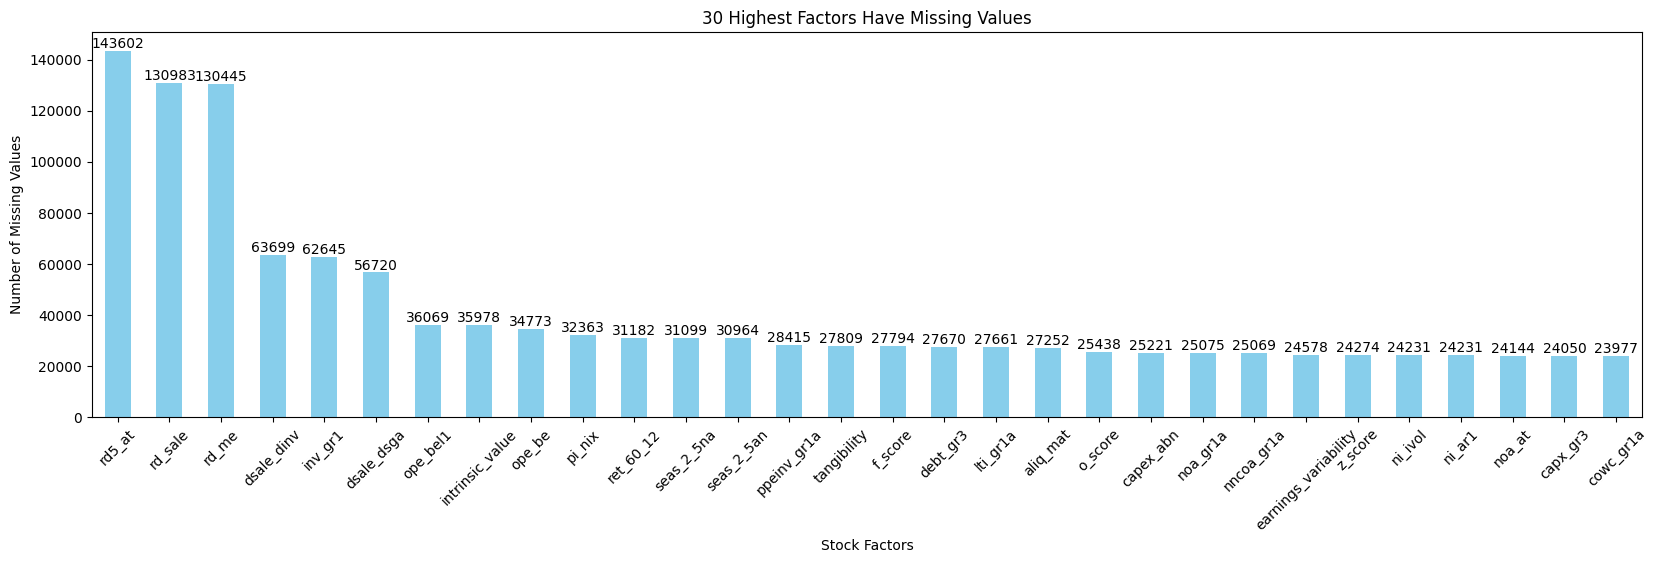

In [9]:
limit = 30

plt.figure(figsize=(20, 5))

missing_values[:limit].plot(
    kind='bar',
    color='skyblue',
    title=f'{limit} Highest Factors Have Missing Values',
    xlabel='Stock Factors',
    ylabel='Number of Missing Values',
    rot=45)

# Add value labels on top of the bars
for index, value in enumerate(missing_values[:limit]):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.show()

<a name="2.2"></a>
### 2.2 - Zero Values

- For **factor/stock factor selection**, factors with too many missing values can lead to biased or unreliable model predictions.
- Factors with **fewer missing values** can be retained and addressed later using imputation methods to fill in the missing values.

In [10]:
zero_values = raw[stock_vars][raw[stock_vars] == 0].count().rename('zero_values')
zero_values = zero_values[zero_values > 0].sort_values(ascending=False)
zero_values

sti_gr1a        104963
div12m_me        99876
ni_inc8q         93724
lti_gr1a         91426
inv_gr1a         55832
                 ...  
tangibility          3
ret_3_1              2
cop_at               1
bidaskhl_21d         1
cop_atl1             1
Name: zero_values, Length: 81, dtype: int64

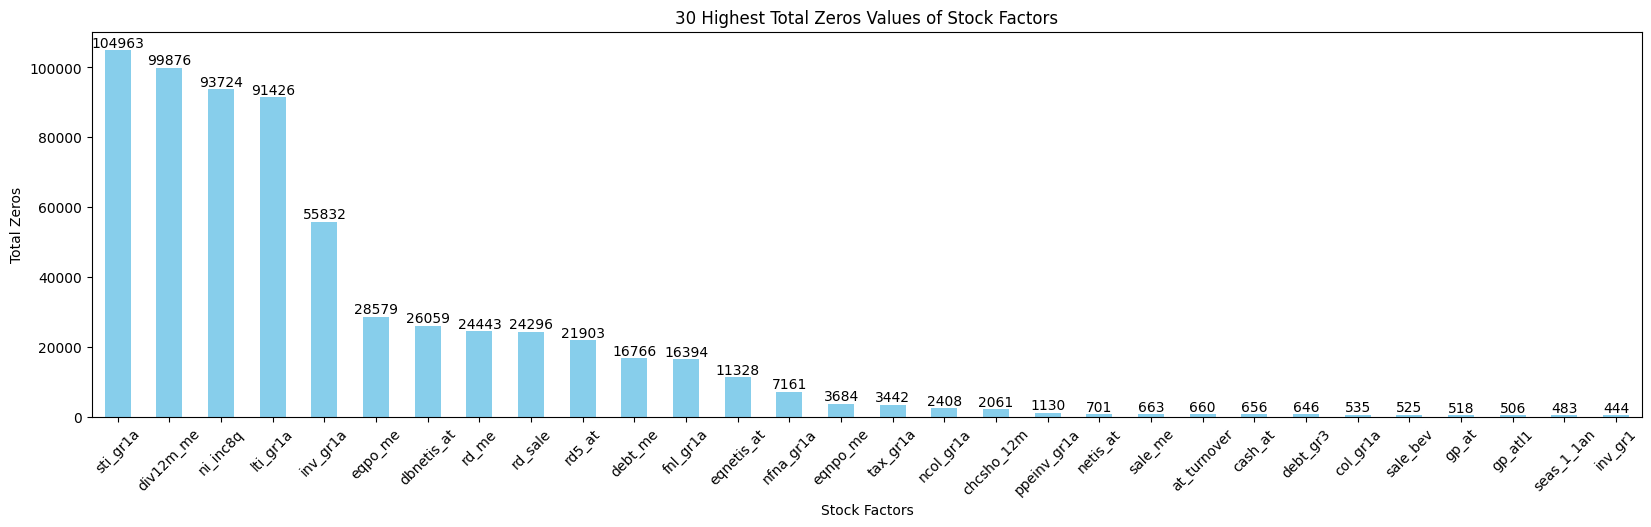

In [11]:
limit = 30

plt.figure(figsize=(20, 5))

zero_values[:limit].plot(
    kind='bar',
    color='skyblue',
    title=f'{limit} Highest Total Zeros Values of Stock Factors',
    xlabel='Stock Factors',
    ylabel='Total Zeros',
    rot=45,
    )

# Add value labels on top of the bars
for index, value in enumerate(zero_values[:limit]):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.show()

<a name="2.3"></a>
### 2.3 - **Number of months** entries avaliable of each **Stock Factor**

- The sample dataset spans **24 years (288 months) from 2000-2024**. However, some stocks do not cover the entire **288-month** period.
- Therefore, selecting stocks with the **highest totals of available months** in the dataset would enhance the models' ability to generalize predictions effectively.

In [12]:
month_counts_by_stock = raw[['permno', 'month']].set_index('month').value_counts().rename('month_count')
stock_counts_by_amount_of_months = month_counts_by_stock.value_counts().rename('stock_count').sort_index(ascending=False)
stock_counts_by_amount_of_months

month_count
288    199
287     34
286     11
285     13
284     11
      ... 
5       83
4       72
3      114
2      122
1      155
Name: stock_count, Length: 283, dtype: int64

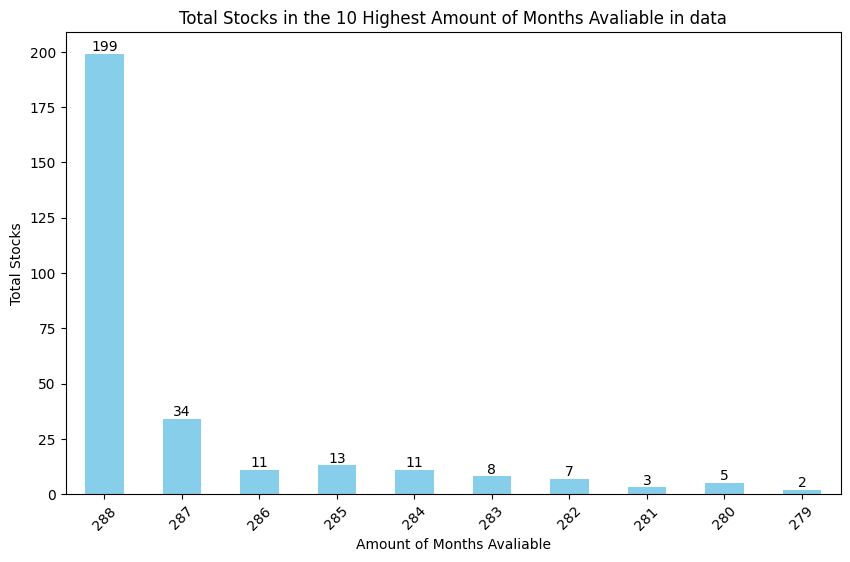

In [13]:
limit = 10

plt.figure(figsize=(10, 6))

stock_counts_by_amount_of_months[:limit].plot(
    kind='bar',
    color='skyblue',
    title=f'Total Stocks in the {limit} Highest Amount of Months Avaliable in data',
    xlabel='Amount of Months Avaliable',
    ylabel='Total Stocks',
    rot=45)

# Add value labels on top of the bars
for index, value in enumerate(stock_counts_by_amount_of_months[:limit]):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.show()

<a name="2.4"></a>
### 2.4 - Clean data

#### Description

To ensure the integrity of the dataset, we will implement a function that cleans the data. This function will focus on selecting factors and stocks based on specific criteria regarding missing and zero values.

Select **factors** that has:
- *Missing Values:* **Least** amount of **missing values** keep factors with less than **30%** missing values.
- *Zero Values:* **Least** amount of **zeros values**: keep factors with less than **20%** zero values

Select **stocks** that has:
- *Available Months:* **Least** amount of **missing months**(**Highest** amount of **available months**)
- *All Missing Values:* **Remove** stocks that have factor(s) contains all missing values

Fill missing values with special methods (Drop stocks one that have all missing values):
  - **Mean/Median:** ```For smaller gaps, you can fill missing values with the mean or median of the available data. This method is simple but may not capture the temporal dynamics of the data effectively.```

**Ranking** and **Normalization**: Implements the vectorized approach for ranking (was a part in provided file `penalized_linear_hackathon.py`.)
- *Ranking*: assign a rank to each factor based on its values, which can be crucial for understanding the relative performance of different stocks.
- *Normalization*: adjust the values in the dataset to a common scale, which is essential for ensuring that the ranking is not biased by the scale of the factors, ensuring that all factors contribute equally to the ranking process.

#### Implement

In [14]:
def cleandata(input_factor: list,
              raw: pd.DataFrame,
              missing_values_percent_threshold=0.30, # Keep factors that have lower missing values percentage than this
              zero_values_percent_threshold=0.20, # Keep factors that have lower zero values percentage than this
              months_threshold=100 # Keep stocks that have higher number of months data than this
              ) -> pd.DataFrame:

  clean_data = raw[input_factor]
  total_entries = len(clean_data)
  left_hand_side_vars = ['year', 'month', 'date', 'permno', 'comp_name', 'stock_exret'] # those are not part of the factors, but should be kept



  # SELECT FACTORS
  # Get least missing values factors (30% threshold default)
  missing_values = clean_data.isnull().sum()
  least_missing_factors = missing_values[missing_values < total_entries * missing_values_percent_threshold].index

  # Get least zero values factors (20% threshold default)
  zero_values = (clean_data == 0).sum()
  least_zero_factors = zero_values[zero_values < total_entries * zero_values_percent_threshold].index
  clean_factor = list(set(least_missing_factors) & set(least_zero_factors))
  clean_data = clean_data[clean_factor]



  # SELECT STOCKS
  # Merge data with `left_hand_side_vars` from `raw`
  clean_data = pd.concat([raw[left_hand_side_vars], clean_data], axis=1)

  # Remove stocks that have factor(s) containing all missing values in any factor
  clean_data = clean_data.groupby('permno').filter(lambda x: not x[clean_factor].isnull().all().any())

  # Select stocks that have least missing
  month_counts_by_stock = clean_data[['permno', 'month']].set_index('month').value_counts().rename('month_count') #value_counts() already sort
  select_permno = month_counts_by_stock[month_counts_by_stock >= months_threshold].reset_index()['permno']
  clean_data = clean_data[clean_data['permno'].isin(select_permno)]



  # FILLING MISSING VALUES
  # Calculate the median for each factor and fill missing values
  medians = clean_data.groupby('permno')[clean_factor].transform('median')

  # Fill missing values with the corresponding median
  clean_data[clean_factor] = clean_data[clean_factor].fillna(medians)

  clean_data[clean_factor] = clean_data[clean_factor].astype(float)




  # RANKING AND NORMALIZATION
  # Rank all selected factors for each stock (permno)
  clean_data[clean_factor] = clean_data.groupby('permno')[clean_factor].rank(method="dense") - 1
  max_ranks = clean_data.groupby('permno')[clean_factor].transform('max')

  # Normalize the ranked values to the range [-1, 1]
  normalized_data = (clean_data[clean_factor] / max_ranks) * 2 - 1
  normalized_data[max_ranks == 0] = 0   # Avoid division by zero by checking where max_ranks == 0 and setting those values to 0
  clean_data[clean_factor] = normalized_data


  return clean_factor, clean_data

In [15]:
factor, data = cleandata(stock_vars, raw)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140162 entries, 0 to 273372
Columns: 145 entries, year to qmj_safety
dtypes: datetime64[ns](1), float64(140), int64(3), object(1)
memory usage: 156.1+ MB


In [16]:
# Save
outputData(factor, data)

Saved `clean_data\factor.csv`.
Saved `clean_data\data.csv`.


#### Cleaned data subset that contains stocks have full 288 months

In [17]:
# factors_288_months, data_288_months = cleandata(stock_vars, raw, months_threshold=288)
# data_288_months.info()
# outputData(factors_288_months, data_288_months, data_file=os.path.join(CLEAN_DATA_FOLDER, 'data_288_months.csv'), factor_file=os.path.join(CLEAN_DATA_FOLDER, 'factor_288_months.csv'))

<a name="2.5"></a>
### 2.5 - Extract Factors and Stocks

We experimented with two different approaches: Heterogeneous Ensembles and RFE with n_estimators=500. Ultimately, we chose the one that produced the most favorable results.

Feature Selection Techniques
<div style="text-align:center"><img src="https://www.mdpi.com/logistics/logistics-05-00080/article_deploy/html/images/logistics-05-00080-g003.png" width="70%"></div>

*Source: [Survey of feature selection and extraction techniques for stock market prediction](https://jfin-swufe.springeropen.com/articles/10.1186/s40854-022-00441-7#Sec23)*

#### Extracting Function

In [18]:
def load_and_extract_data(data: pd.DataFrame,
                          selected_factors=[],
                          selected_stocks=[],
                          rand_factors=False,
                          rand_stocks=False):

  stock_permnos = data['permno'].unique().tolist()

  # Selecting random factors
  if rand_factors:
    num_factors = random.randint(*rand_factors) # Must be below 147
    selected_factors = random.sample(selected_factors, num_factors)
  else:
    selected_factors = selected_factors

  print(f"[{len(selected_factors)}] Selected factors: {selected_factors}")

  # Selecting random Stocks
  if rand_stocks:
    num_stocks = random.randint(*rand_stocks) # Should be around 50-100
    selected_stocks = random.sample(stock_permnos, num_stocks)
  else:
    selected_stocks = stock_permnos

  print(f"[{len(selected_stocks)}] Selected Stocks")


  extract_data = data[data['permno'].isin(selected_stocks)][['date', 'year', 'month', 'permno', 'stock_exret'] + selected_factors]

  return selected_factors, extract_data

<a name="2.5.1"></a>
### 2.5.1 - **Heterogeneous ensembles** approach

#### Description

We initially explored *Heterogeneous Ensembles*, a method highlighted in various research papers, which appeared promising for our needs.

Using a **Hybrid Ensembles** approach for feature selection involves leveraging a subset of data through **Homogeneous Ensembles** and combining different algorithms via **Heterogeneous Ensembles**.

- **Homogeneous Ensembles**: In this approach, the same feature selection method is applied across different subsets of training data.
  >"*In the homogeneous approach, the same feature selection method is used, but with different training data subsets.*"
  <div style="text-align:center"><img src="https://ars.els-cdn.com/content/image/1-s2.0-S1566253518303440-gr2.jpg" width="70%"></div>

- **Heterogeneous Ensembles**: This method employs various feature selection techniques on the same training data, allowing for a more diverse selection process.
  >"*For the heterogeneous approach, a number of different feature selection methods, but over the same training data, are applied*"
  <div style="text-align:center"><img src="https://ars.els-cdn.com/content/image/1-s2.0-S1566253518303440-gr3.jpg" width="70%"></div>

<br>

Next, we utilized the *Union* method to combine the selected features:

> "The union consists in combining all the features which have been selected by at least one of the feature selectors. Contrary to the intersection, it can lead to select even the whole set of features. This approach tends to produce better results than the intersection [41], but at the expense of a lower reduction in the number of the features."

*Source: [Ensembles for feature selection: A review and future trends](https://www.sciencedirect.com/science/article/pii/S1566253518303440?casa_token=Gppypu5uSqgAAAAA:mYcUqLgqUqCJWRMOw85cOnnlCdUQiL6Y5cjvA1dv7riCTHEwBL9pLZNauKmEuO8un3rkPl1WdQ)*

This structured approach allowed us to effectively harness the strengths of both homogeneous and heterogeneous ensembles for feature selection, ultimately enhancing our model's performance.

#### Wrap Functions

In [19]:
# 1. Filter Method: Pearson Correlation Analysis
def correlation_selection(X, y, k=10):
  cor = pd.DataFrame(X.corrwith(y)).abs()
  selected_features = cor[:k].index.tolist()
  return X[selected_features]

# 2. Filter Method: Mutual Information
def mutual_info_selection(X, y, k=10):
  mi = mutual_info_regression(X, y)
  mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
  selected_features = mi_series.nlargest(k).index.tolist()
  return X[selected_features]

# 3. Wrapper Method: Recursive Feature Elimination
def rfe_selection(X, y, k=10):
  estimator = XGBRegressor(random_state=42)
  param_grid = {
      'n_estimators': [5, 10],
      'learning_rate': [0.01, 0.1, 0.2]
  }
  grid_search = GridSearchCV(estimator, param_grid, cv=5, scoring='neg_mean_squared_error')
  grid_search.fit(X, y)
  selector = RFE(grid_search.best_estimator_, n_features_to_select=k, step=1)
  selector = selector.fit(X, y)
  selected_features = X.columns[selector.support_].tolist()
  return X[selected_features]

# 4. Embedded Method: Lasso
def lasso_selection(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    lasso_cv = LassoCV(alphas=[0.001], cv=5)
    lasso_cv.fit(X, y)
    selected_features = X.columns[lasso_cv.coef_ != 0].tolist()
    return X[selected_features]

# 5. Embedded Method: Elastic Net
def elastic_net_selection(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    enet_cv = ElasticNetCV(alphas=[0.001], l1_ratio=[0.1, 0.5, 0.9, 1], cv=5)
    enet_cv.fit(X, y)
    selected_features = X.columns[enet_cv.coef_ != 0].tolist()
    return X[selected_features]

# 6. Embedded Method: XGBoost Feature Importance
def rf_importance_selection(X, y, k=10):
    rf = XGBRegressor(random_state=42)
    param_grid = {
        'n_estimators': [5, 10],
        'learning_rate': [0.01, 0.1, 0.2],
    }
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X, y)
    # Get feature importances from the best XGBoost estimator
    importances = pd.Series(grid_search.best_estimator_.feature_importances_, index=X.columns).sort_values(ascending=False)
    selected_features = importances.nlargest(k).index.tolist()
    return X[selected_features]



# Evaluation function
def evaluate_model(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Train a simple XGBoost model
  model = XGBRegressor(random_state=42)
  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)
  mse = mean_squared_error(y_test, y_pred)
  return mse

#### Implement

In [20]:
sample_factor, sample_data = load_and_extract_data(data, selected_factors=factor, rand_stocks=(50, 50))
# factors_288_months, data_288_months = inputData(data_file=os.path.join(CLEAN_DATA_FOLDER 'data_288_months.csv'), factor_file=os.path.join(CLEAN_DATA_FOLDER, 'factor_288_months.csv'))
# sample_factor, sample_data = load_and_extract_data(factors_288_months, data_288_months, rand_stocks=(50, 50))

X, y = sample_data[sample_factor], sample_data['stock_exret']
X.info()

[139] Selected factors: ['fcf_me', 'emp_gr1', 'seas_2_5an', 'sale_gr3', 'ivol_ff3_21d', 'nncoa_gr1a', 'taccruals_at', 'seas_2_5na', 'debt_gr3', 'dolvol_126d', 'resff3_12_1', 'at_be', 'tax_gr1a', 'betadown_252d', 'ivol_capm_252d', 'op_at', 'pi_nix', 'rvol_21d', 'chcsho_12m', 'be_me', 'ocf_at', 'intrinsic_value', 'aliq_at', 'coa_gr1a', 'ami_126d', 'dbnetis_at', 'ocf_at_chg1', 'tangibility', 'debt_me', 'niq_be_chg1', 'corr_1260d', 'ppeinv_gr1a', 'prc', 'ret_3_1', 'cop_at', 'at_gr1', 'ni_ar1', 'nfna_gr1a', 'cop_atl1', 'opex_at', 'ope_bel1', 'gp_atl1', 'beta_60m', 'col_gr1a', 'eqnpo_12m', 'iskew_hxz4_21d', 'capx_gr1', 'turnover_var_126d', 'oaccruals_at', 'be_gr1a', 'niq_su', 'ni_me', 'o_score', 'eqpo_me', 'capx_gr2', 'seas_1_1an', 'netis_at', 'inv_gr1', 'ebitda_mev', 'ope_be', 'oaccruals_ni', 'sale_gr1', 'ret_1_0', 'ncoa_gr1a', 'zero_trades_126d', 'earnings_variability', 'sale_emp_gr1', 'eqnpo_me', 'ncol_gr1a', 'niq_at_chg1', 'netdebt_me', 'ni_ivol', 'niq_be', 'at_me', 'dsale_drec', 'rmax5_

In [21]:
# Record the start time for the entire process
start_time = datetime.datetime.now()

# Function to time each feature selection method
def time_feature_selection(method_name, method, *args):
    start = datetime.datetime.now()
    result = method(*args)
    end = datetime.datetime.now()
    duration = end - start

    # Convert duration to seconds
    total_seconds = duration.total_seconds()
    minutes = int(total_seconds // 60)
    seconds = int(total_seconds % 60)

    # Format minutes and seconds as MM:SS
    formatted_time = f"{minutes:02}:{seconds:02}"
    print(f"{method_name} completed in: {formatted_time}")
    return result

# Apply feature selection methods with timing
X_corr = time_feature_selection("Correlation selection", correlation_selection, X, y)
X_mi = time_feature_selection("Mutual information selection", mutual_info_selection, X, y)
X_rfe = time_feature_selection("RFE selection", rfe_selection, X, y)
X_lasso = time_feature_selection("Lasso selection", lasso_selection, X, y)
X_enet = time_feature_selection("Elastic Net selection", elastic_net_selection, X, y)
X_rf = time_feature_selection("XGBoost feature importance selection", rf_importance_selection, X, y)

# Record the end time for the entire process
end_time = datetime.datetime.now()
total_duration = end_time - start_time

# Convert total duration to minutes and seconds
total_seconds = total_duration.total_seconds()
total_minutes = int(total_seconds // 60)
total_seconds = int(total_seconds % 60)

# Format total running time as MM:SS
total_formatted_time = f"{total_minutes:02}:{total_seconds:02}"
print(f"Total running time for all methods: {total_formatted_time}")

Correlation selection completed in: 00:00
Mutual information selection completed in: 00:10
RFE selection completed in: 00:33
Lasso selection completed in: 00:00
Elastic Net selection completed in: 00:00
XGBoost feature importance selection completed in: 00:11
Total running time for all methods: 00:55


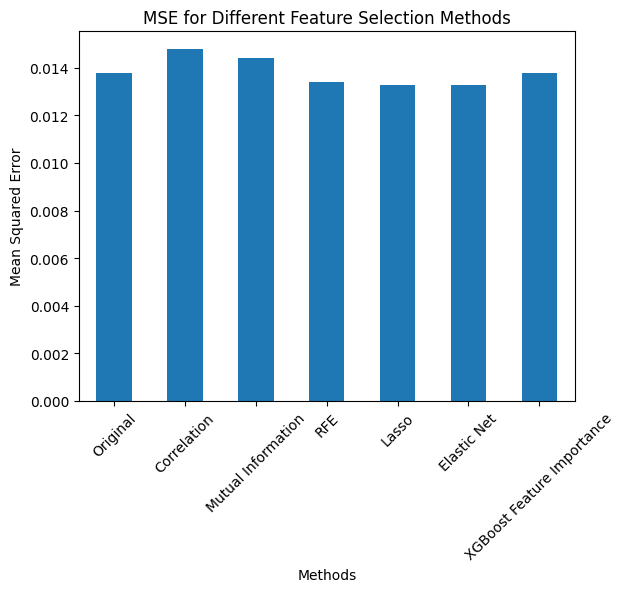

In [22]:
feature_selection_methods = {
    'Original': X,
    'Correlation': X_corr,
    'Mutual Information': X_mi,
    'RFE': X_rfe,
    'Lasso': X_lasso,
    'Elastic Net': X_enet,
    'XGBoost Feature Importance': X_rf,
}

results = []

# Evaluate each method
for method_name, X_selected in feature_selection_methods.items():
    if X_selected.shape[1] > 0:
        results.append([method_name, evaluate_model(X_selected, y)])
    else:
        results.append([method_name, float('inf')])

results = pd.DataFrame(results, columns=['Methods', 'MSE'])

# Plotting results
results.plot(
    kind='bar',
    x='Methods',
    y='MSE',
    title='MSE for Different Feature Selection Methods',
    ylabel='Mean Squared Error',
    rot=45,
    legend=False
)

features_df = pd.DataFrame(dict([(k, pd.Series(v.columns)) for k, v in list(feature_selection_methods.items())[1:]]))

In [23]:
print("\nSelected Features from Each Method:")
features_df


Selected Features from Each Method:


,Correlation,Mutual Information,RFE,Lasso,Elastic Net,XGBoost Feature Importance
0,fcf_me,prc_highprc_252d,iskew_hxz4_21d,seas_2_5an,seas_2_5an,intrinsic_value
1,emp_gr1,at_turnover,ebitda_mev,nncoa_gr1a,nncoa_gr1a,coskew_21d
2,seas_2_5an,bidaskhl_21d,oaccruals_ni,dolvol_126d,dolvol_126d,at_me
3,sale_gr3,seas_1_1na,at_me,betadown_252d,betadown_252d,market_equity
4,ivol_ff3_21d,be_me,beta_dimson_21d,pi_nix,pi_nix,ebitda_mev
5,nncoa_gr1a,ret_6_1,sale_me,be_me,be_me,oaccruals_ni
6,taccruals_at,ret_3_1,coskew_21d,ami_126d,ami_126d,rmax5_21d
7,seas_2_5na,ivol_capm_252d,prc_highprc_252d,dbnetis_at,dbnetis_at,op_at
8,debt_gr3,coskew_21d,seas_1_1na,debt_me,debt_me,turnover_126d
9,dolvol_126d,ivol_capm_21d,market_equity,corr_1260d,corr_1260d,betabab_1260d


In [24]:
# Union all features from all methods
all_selected_features = pd.concat([features_df[col] for col in features_df.columns]).dropna().drop_duplicates().reset_index(drop=True)
print(f'Total Selected Features: {len(all_selected_features)} {all_selected_features}')

Total Selected Features: 49 0               fcf_me
1              emp_gr1
2           seas_2_5an
3             sale_gr3
4         ivol_ff3_21d
5           nncoa_gr1a
6         taccruals_at
7           seas_2_5na
8             debt_gr3
9          dolvol_126d
10    prc_highprc_252d
11         at_turnover
12        bidaskhl_21d
13          seas_1_1na
14               be_me
15             ret_6_1
16             ret_3_1
17      ivol_capm_252d
18          coskew_21d
19       ivol_capm_21d
20      iskew_hxz4_21d
21          ebitda_mev
22        oaccruals_ni
23               at_me
24     beta_dimson_21d
25             sale_me
26       market_equity
27       betadown_252d
28              pi_nix
29            ami_126d
30          dbnetis_at
31             debt_me
32          corr_1260d
33            capx_gr1
34        oaccruals_at
35             be_gr1a
36          seas_1_1an
37            sale_gr1
38    zero_trades_126d
39      rmax5_rvol_21d
40                 age
41          qmj_growth
42    

In [25]:
selected_factor_heterogeneous, selected_data_heterogeneous = load_and_extract_data(data, selected_factors=all_selected_features.tolist())
# outputData(selected_factor, selected_data, data_file=os.path.join(CLEAN_DATA_FOLDER, 'selected_data.csv'), factor_file=os.path.join(CLEAN_DATA_FOLDER, 'selected_factor.csv'))

[49] Selected factors: ['fcf_me', 'emp_gr1', 'seas_2_5an', 'sale_gr3', 'ivol_ff3_21d', 'nncoa_gr1a', 'taccruals_at', 'seas_2_5na', 'debt_gr3', 'dolvol_126d', 'prc_highprc_252d', 'at_turnover', 'bidaskhl_21d', 'seas_1_1na', 'be_me', 'ret_6_1', 'ret_3_1', 'ivol_capm_252d', 'coskew_21d', 'ivol_capm_21d', 'iskew_hxz4_21d', 'ebitda_mev', 'oaccruals_ni', 'at_me', 'beta_dimson_21d', 'sale_me', 'market_equity', 'betadown_252d', 'pi_nix', 'ami_126d', 'dbnetis_at', 'debt_me', 'corr_1260d', 'capx_gr1', 'oaccruals_at', 'be_gr1a', 'seas_1_1an', 'sale_gr1', 'zero_trades_126d', 'rmax5_rvol_21d', 'age', 'qmj_growth', 'iskew_ff3_21d', 'iskew_capm_21d', 'intrinsic_value', 'rmax5_21d', 'op_at', 'turnover_126d', 'betabab_1260d']
[680] Selected Stocks


<a name="2.5.2"></a>
### 2.5.2 - RFE with `n_estimators=500`

#### Description

Using **Recursive Feature Elimination (RFE)** with an **XGBoost regressor** is an effective for identifying the most important features when predicting stock excess returns. RFE is a popular feature selection algorithm that works by recursively removing the least important features based on the model's performance, allowing the model to focus on the most relevant information.

The process ensures that the model is trained on a well-structured with `500 estimators` and relevant subset of the data, which can enhance its predictive performance.

#### Implement

In [26]:
# Features and target variable selection
X = data.drop(columns=['stock_exret', 'comp_name', 'date', 'permno', 'year', 'month'])
y = data['stock_exret']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled arrays back to DataFrames to keep column names
X_train_scaled_data = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled_data = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Feature selection using RFE
n_features_to_select = 50  # Specify the number of features to select

# Initialize the estimator for RFE with correct XGBoost parameters
estimator = XGBRegressor(
    n_estimators=500,
    max_depth=None,    # Consider setting a specific depth if needed for control
    learning_rate=0.1,  # XGBoost uses learning_rate (analogous to shrinkage)
    subsample=0.8,      # Control the fraction of samples used
    colsample_bytree=0.8,  # Control the fraction of features used
    random_state=42,
    n_jobs=-1
)

# Initialize RFE with step parameter for faster elimination
selector = RFE(estimator=estimator, n_features_to_select=n_features_to_select, step=5)
selector = selector.fit(X_train_scaled_data, y_train)

# Get selected feature names
selected_factor_RFE = X_train_scaled_data.columns[selector.support_].tolist()
print(f"Top {n_features_to_select} features selected using RFE:")
print(selected_factor_RFE)

Top 50 features selected using RFE:
['prc', 'seas_1_1an', 'ebitda_mev', 'ret_1_0', 'eqnpo_me', 'netdebt_me', 'at_me', 'rmax5_rvol_21d', 'beta_dimson_21d', 'ret_12_1', 'age', 'ebit_bev', 'z_score', 'sale_me', 'mispricing_perf', 'turnover_126d', 'coskew_21d', 'ret_6_1', 'bev_mev', 'ocfq_saleq_std', 'betabab_1260d', 'zero_trades_252d', 'ret_60_12', 'saleq_gr1', 'eq_dur', 'dsale_dsga', 'aliq_mat', 'prc_highprc_252d', 'rmax1_21d', 'rmax5_21d', 'iskew_capm_21d', 'taccruals_ni', 'seas_1_1na', 'ret_12_7', 'ivol_hxz4_21d', 'rskew_21d', 'bidaskhl_21d', 'capx_gr3', 'fnl_gr1a', 'dolvol_var_126d', 'ivol_capm_21d', 'market_equity', 'saleq_su', 'ret_9_1', 'ocf_me', 'zero_trades_21d', 'dgp_dsale', 'cowc_gr1a', 'resff3_6_1', 'qmj_safety']


In [27]:
selected_factor_RFE, selected_data_RFE = load_and_extract_data(data, selected_factors=selected_factor_RFE)
# outputData(selected_factor, selected_data, data_file=os.path.join(CLEAN_DATA_FOLDER, 'selected_data.csv'), factor_file=os.path.join(CLEAN_DATA_FOLDER, 'selected_factor.csv'))

[50] Selected factors: ['prc', 'seas_1_1an', 'ebitda_mev', 'ret_1_0', 'eqnpo_me', 'netdebt_me', 'at_me', 'rmax5_rvol_21d', 'beta_dimson_21d', 'ret_12_1', 'age', 'ebit_bev', 'z_score', 'sale_me', 'mispricing_perf', 'turnover_126d', 'coskew_21d', 'ret_6_1', 'bev_mev', 'ocfq_saleq_std', 'betabab_1260d', 'zero_trades_252d', 'ret_60_12', 'saleq_gr1', 'eq_dur', 'dsale_dsga', 'aliq_mat', 'prc_highprc_252d', 'rmax1_21d', 'rmax5_21d', 'iskew_capm_21d', 'taccruals_ni', 'seas_1_1na', 'ret_12_7', 'ivol_hxz4_21d', 'rskew_21d', 'bidaskhl_21d', 'capx_gr3', 'fnl_gr1a', 'dolvol_var_126d', 'ivol_capm_21d', 'market_equity', 'saleq_su', 'ret_9_1', 'ocf_me', 'zero_trades_21d', 'dgp_dsale', 'cowc_gr1a', 'resff3_6_1', 'qmj_safety']
[680] Selected Stocks


<a name="2.5.3"></a>
### 2.5.3 - Evaluation for Each Technique

In [28]:
# Function to calculate R-squared for a given dataset
def calculate_r_squared(selected_data):
    # Features and target variable selection
    X = selected_data.drop(columns=['stock_exret', 'date', 'permno', 'year', 'month'])
    y = selected_data['stock_exret']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the features using RobustScaler
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize the estimator for RFE with correct XGBoost parameters
    estimator = XGBRegressor(
        n_estimators=500,
        max_depth=None,    # Consider setting a specific depth if needed for control
        learning_rate=0.1,  # XGBoost uses learning_rate (analogous to shrinkage)
        subsample=0.8,      # Control the fraction of samples used
        colsample_bytree=0.8,  # Control the fraction of features used
        random_state=42,
        n_jobs=-1
    )

    # Fit the XGBoost model on the selected features
    estimator.fit(X_train_scaled, y_train)

    # Make predictions on the test set
    y_pred = estimator.predict(X_test_scaled)

    # Calculate and return the R-squared score
    r_squared = r2_score(y_test, y_pred)
    return r_squared

# Assuming selected_factor_RFE and selected_data_RFE are your DataFrames
r_squared_heterogeneous = calculate_r_squared(selected_data_heterogeneous)
r_squared_RFE = calculate_r_squared(selected_data_RFE)

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Method': ['Heterogeneous', 'RFE'],
    'R_squared': [r_squared_heterogeneous, r_squared_RFE]
})
# Determine the best method based on R-squared
best_method = results_df.loc[results_df['R_squared'].idxmax()]

print(f'Best R_squared: {best_method.Method}:{best_method.R_squared}')
results_df

Best R_squared: Heterogeneous:0.12115124873002414


,Method,R_squared
0,Heterogeneous,0.121151
1,RFE,0.119363


In [29]:
# Determine the best method based on R-squared
best_method = results_df.loc[results_df['R_squared'].idxmax()]

# Save the best to a file
if best_method['Method'] == 'selected_factor_RFE':
    outputData(selected_factor_RFE, selected_data_RFE, data_file=os.path.join(CLEAN_DATA_FOLDER, 'selected_data.csv'), factor_file=os.path.join(CLEAN_DATA_FOLDER, 'selected_factor.csv'))
else:
    outputData(selected_factor_heterogeneous, selected_data_heterogeneous, data_file=os.path.join(CLEAN_DATA_FOLDER, 'selected_data.csv'), factor_file=os.path.join(CLEAN_DATA_FOLDER, 'selected_factor.csv'))

Saved `clean_data\selected_factor.csv`.
Saved `clean_data\selected_data.csv`.


#### Read Extracted Data and Factors

In [30]:
selected_factor, selected_data = inputData(data_file=os.path.join(CLEAN_DATA_FOLDER, 'selected_data.csv'), factor_file=os.path.join(CLEAN_DATA_FOLDER, 'selected_factor.csv'))

Read `clean_data\selected_factor.csv`.
Read `clean_data\selected_data.csv`.


<a name="2.6"></a>
### 2.6 - Ramdom sample (for testing)

In [31]:
# selected_factors, selected_stocks = extract_data(rand_factors=(10, 30), rand_stocks=(50, 100))

<a name="3"></a>
## 3 - Run Prediction

In [32]:
%run predict_data.py --data=selected_data.csv --factor=selected_factor.csv --work_dir={CLEAN_DATA_FOLDER} --output_dir={PREDICTED_FOLDER}

2025-04-10 01:56:59.404516
Read `clean_data\selected_factor.csv`.
Read `clean_data\selected_data.csv`.
[Processing...] Train:2000-2010 | Predict:2010-2011 | 03:41
[Processing...] Train:2000-2011 | Predict:2011-2012 | 06:56
[Processing...] Train:2000-2012 | Predict:2012-2013 | 10:15
[Processing...] Train:2000-2013 | Predict:2013-2014 | 13:39
[Processing...] Train:2000-2014 | Predict:2014-2015 | 17:07
[Processing...] Train:2000-2015 | Predict:2015-2016 | 20:43
[Processing...] Train:2000-2016 | Predict:2016-2017 | 24:24
[Processing...] Train:2000-2017 | Predict:2017-2018 | 28:11
[Processing...] Train:2000-2018 | Predict:2018-2019 | 32:02
[Processing...] Train:2000-2019 | Predict:2019-2020 | 35:58
[Processing...] Train:2000-2020 | Predict:2020-2021 | 40:01
[Processing...] Train:2000-2021 | Predict:2021-2022 | 44:07
[Processing...] Train:2000-2022 | Predict:2022-2023 | 48:17
[Processing...] Train:2000-2023 | Predict:2023-2024 | 52:33
Total Time: 52:33
Saved `predictions\output.csv`.
ols: -0

In [33]:
# Old Models

# %run penalized_linear_hackathon.py --data=selected_data.csv --factor=selected_factor.csv --work_dir={CLEAN_DATA_FOLDER} --output_dir={PREDICTED_FOLDER}

<a name="4"></a>
## 4 - Models Evaluation

In [34]:
%run portfolio_analysis_hackathon.py --predicted=output.csv --model=xgb --mkt_ind={ASSET_MKT_IND_PATH} --work_dir={PREDICTED_FOLDER}

Sharpe Ratio: 3.5640999685781756
                            OLS Regression Results                            
Dep. Variable:                port_11   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.1542
Date:                Thu, 10 Apr 2025   Prob (F-statistic):              0.695
Time:                        02:49:39   Log-Likelihood:                 313.12
No. Observations:                 168   AIC:                            -622.2
Df Residuals:                     166   BIC:                            -616.0
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.03

In [35]:
# for model_name in ['ols', 'lasso', 'ridge', 'en', 'xgb']:
#   print(f'\n\n{model_name}: ')
# %run portfolio_analysis_hackathon.py --predicted='output.csv' --model='{model_name}' --mkt_ind={ASSET_MKT_IND_PATH} --work_dir='{PREDICTED_FOLDER}'

<a name="5"></a>
## 5 - Cumulative Performance

#### Wrap Functions

In [36]:
# Create mixed strategy with long and short positions
def mixed_strategy(df, n_stocks, long_short_split=0.7, model="xgb"):
    long_n = int(n_stocks * long_short_split)  # Number of long positions
    short_n = n_stocks - long_n  # Number of short positions
    top_n = df.nlargest(long_n, model)  # Top long_n for long
    bottom_n = df.nsmallest(short_n, model)  # Bottom short_n for short
    return top_n, bottom_n

def create_portfolios(pred, n_stocks):
    monthly_portfolios = []
    for _, group in pred.groupby(['date']):
        long_stocks, short_stocks = mixed_strategy(group, n_stocks=n_stocks, long_short_split=0.7)
        long_stocks['position'] = 1  # Long position
        short_stocks['position'] = -1  # Short position
        combined = pd.concat([long_stocks, short_stocks])
        monthly_portfolios.append(combined)

    combined_portfolio = pd.concat(monthly_portfolios)

    return combined_portfolio

def compute_weighted_return(portfolio):
    # Combine the monthly portfolios
    portfolio['weighted_return'] = portfolio['stock_exret'] * portfolio['position']
    # Aggregate and calculate the performance
    monthly_performance = portfolio.groupby(['year', 'month', 'date']).agg({'weighted_return': 'mean'}).reset_index()

    return monthly_performance

# Iterate through numbers from 50 to 100 and find the one with the highest Sharpe Ratio
def find_best_number_of_portfolios(pred, from_=50, to=100):
    best_sharpe = -np.inf  # Initialize best Sharpe ratio as negative infinity
    best_n_stocks = None  # Initialize best number of stocks

    print(f'Finding best number of stocks... ', end='')

    for n_stocks in range(from_, to+1):  # Loop through numbers from 50 to 100
        mixed_portfolio = create_portfolios(pred, n_stocks)
        monthly_performance = compute_weighted_return(mixed_portfolio)

        # Calculate the Sharpe Ratio for this portfolio
        sharpe = calculate_sharpe_ratio(monthly_performance)

        # Check if this is the highest Sharpe ratio
        if sharpe > best_sharpe:
            best_sharpe = sharpe
            best_n_stocks = n_stocks

    print(f"| Best number of stocks:{best_n_stocks} | Sharpe Ratio:{best_sharpe}")

    return best_n_stocks, best_sharpe

# Calculate the Sharpe Ratio for a given portfolio
def calculate_sharpe_ratio(portfolio):
    mean_return = portfolio['weighted_return'].mean()
    std_dev = portfolio['weighted_return'].std()
    sharpe = mean_return / std_dev * np.sqrt(12)  # Annualized Sharpe ratio
    return sharpe

# Calculate the annualized return
def annualized_return(monthly_returns):
    compounded_growth = (1 + monthly_returns).prod()
    n_months = len(monthly_returns)
    annual_return = compounded_growth**(12 / n_months) - 1
    return annual_return

# Calculate the annualized standard deviation
def annualized_std(monthly_returns):
    monthly_std = monthly_returns.std()
    annualized_std = monthly_std * np.sqrt(12)
    return annualized_std

# Plot Cumulative Performance of Mixed Strategy Portfolio vs S&P 500
def plot_cumulative(monthly_performance):
    plt.figure(figsize=(10, 6))
    plt.plot(monthly_performance['year'] + monthly_performance['month']/12, monthly_performance['cumulative_portfolio'], label="Mixed Strategy Portfolio")
    plt.plot(monthly_performance['year'] + monthly_performance['month']/12, monthly_performance['cumulative_sp500'], label="S&P 500", linestyle="--")
    plt.title('Cumulative Performance: Mixed Strategy vs. S&P 500 (2010–2023)')
    plt.xlabel('Year')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid(True)

<a name="5.1"></a>
### 5.1 - Plot Cumulative Performance: Mixed Strategy vs. S&P 500 (2010–2023)

Finding best number of stocks... | Best number of stocks:51 | Sharpe Ratio:2.725219713096609
Final portfolio Sharpe ratio: 2.725219713096609
Portfolio Annualized Return: 0.3796
Portfolio Annualized Standard Deviation: 0.1223


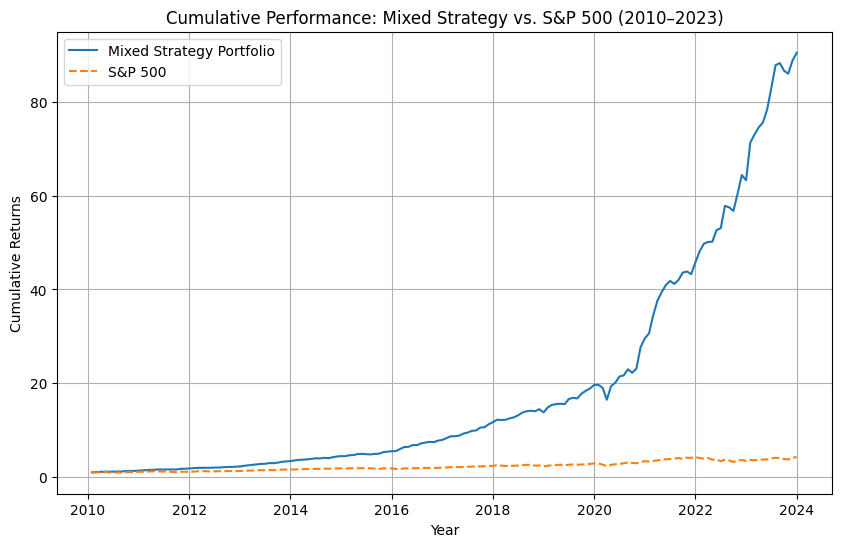

In [37]:
mkt = pd.read_csv(ASSET_MKT_IND_PATH)
pred = pd.read_csv(OUTPUT_PREDICTS_PATH, parse_dates=["date"])

# Filter for OOS testing period: 01/2010 to 12/2023
pred = pred[(pred['date'] >= '2010-01-01') & (pred['date'] <= '2023-12-31')]

# Select model (e.g., 'xgb')
model = "xgb"

best_n_stocks, best_sharpe = find_best_number_of_portfolios(pred)

# Now create the final portfolio using the best number of stocks
final_portfolio = create_portfolios(pred, best_n_stocks)

# Calculate the performance
monthly_performance = compute_weighted_return(final_portfolio)
print(f"Final portfolio Sharpe ratio: {calculate_sharpe_ratio(monthly_performance)}")

# Calculate and print the overall annualized return and standard deviation
portfolio_annual_return = annualized_return(monthly_performance['weighted_return'])
portfolio_annual_std = annualized_std(monthly_performance['weighted_return'])

print(f"Portfolio Annualized Return: {portfolio_annual_return:.4f}")
print(f"Portfolio Annualized Standard Deviation: {portfolio_annual_std:.4f}")

# Merge with S&P 500 returns for comparison

monthly_performance = monthly_performance.merge(mkt, how="inner", on=["year", "month"])
monthly_performance["cumulative_portfolio"] = (1 + monthly_performance["weighted_return"]).cumprod()
monthly_performance["cumulative_sp500"] = (1 + monthly_performance["sp_ret"]).cumprod()

#############
plot_cumulative(monthly_performance)

<a name="5.2"></a>
### 5.2 - 10 most held stocks in our portfolio

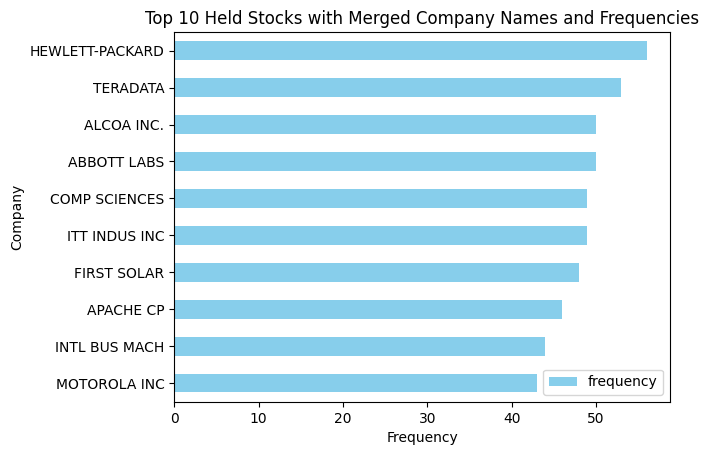

In [38]:
n_top = 10

# Count the number of appearances of each stock (permno) across all months in the final portfolio
stock_counts = final_portfolio['permno'].value_counts().rename('frequency').reset_index()
# Get the top 10 most frequently held stocks
top_n_stocks = stock_counts.head(n_top).merge(raw.drop_duplicates(subset='permno')[['permno', 'comp_name']], on='permno', how='left')
top_n_stocks.plot(kind='barh',
                   x='comp_name',
                   y='frequency',
                   color='skyblue',
                  xlabel='Frequency',
                  ylabel='Company',
                  title=f'Top {n_top} Held Stocks with Merged Company Names and Frequencies').invert_yaxis()

___________________________________________

In [39]:
# Export this notebook into script `.py` file
# jupyter nbconvert --to script main_notebook.ipynb

In [40]:
# Run the script `.py` file
# ipython main_notebook.py